In [1]:
import sys

sys.path.append('../..')
sys.path

['/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python39.zip',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/lib-dynload',
 '',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages',
 '../..']

In [2]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


2024-12-20 20:18:17.673298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 20:18:17.674411: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 20:18:17.677300: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 20:18:17.685719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734722297.700250   51744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734722297.70

In [3]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]

Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:06<00:00, 26.42it/s]
INFO:root:Read in 10.7674241065979 seconds
INFO:root:It is possible stratified split? True
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: fault,unit,DE
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)


In [4]:
def extraer_envolventes(serie_temporal, tiempo=None):
    """
    Extrae las envolventes superior e inferior de una serie temporal.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal (1D).
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usa un índice lineal.

    Returns:
        tuple: (envolvente_superior, envolvente_inferior)
    """
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Encontrar picos máximos (envolvente superior)
    picos_superior, _ = find_peaks(serie_temporal)
    # Encontrar picos mínimos (envolvente inferior)
    picos_inferior, _ = find_peaks(-serie_temporal)
    
    # Interpolación para generar las envolventes
    interp_superior = interp1d(tiempo[picos_superior], serie_temporal[picos_superior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    interp_inferior = interp1d(tiempo[picos_inferior], serie_temporal[picos_inferior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    
    envolvente_superior = interp_superior(tiempo)
    envolvente_inferior = interp_inferior(tiempo)
    
    return envolvente_superior, envolvente_inferior

def ajustar_pendiente_y_escalar(serie_temporal, pendiente_objetivo, tiempo=None):
    """
    Ajusta una serie temporal para que su pendiente de regresión sea la indicada,
    y escala los valores para que los máximos y mínimos coincidan con la serie original.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        pendiente_objetivo (float): Pendiente deseada para la línea de regresión.
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usará un índice lineal.

    Returns:
        numpy.ndarray: Serie temporal ajustada y escalada.
    """
    # Generar tiempo si no está dado
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Calcular la pendiente actual usando regresión lineal
    tiempo = tiempo.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(tiempo, serie_temporal)
    pendiente_actual = reg.coef_[0]
    
    # Calcular el ajuste necesario
    ajuste_pendiente = pendiente_objetivo - pendiente_actual
    
    # Modificar la serie para lograr la pendiente deseada
    serie_ajustada = serie_temporal + ajuste_pendiente * (tiempo.flatten() - tiempo.mean())
    
    # Escalar la serie ajustada para que sus máximos y mínimos coincidan con los originales
    min_original, max_original = serie_temporal.min(), serie_temporal.max()
    min_ajustada, max_ajustada = serie_ajustada.min(), serie_ajustada.max()
    
    # Escalamiento lineal
    serie_escalada = ((serie_ajustada - min_ajustada) / (max_ajustada - min_ajustada)) * (max_original - min_original) + min_original
    
    return serie_escalada



def prepare_data(X, signal_col, subsignal_length = 1000, signal_max_length = 20000):

    units_array = X.unit.values
    signal_array = X[signal_col].values
    targets = X[['unit','fault']].drop_duplicates().set_index('unit').fault.to_dict()

    N = signal_max_length // subsignal_length
    X = np.zeros((N*len(targets.keys()), subsignal_length))
    Y = np.zeros((N*len(targets.keys()), 0)) 

    NN = 0
    for i, unit in enumerate(targets.keys()):
        mask = units_array == unit
        signal = signal_array[mask]

        sml = (signal.shape[0] // subsignal_length) * subsignal_length
        n = min(sml // subsignal_length, N)
        sml = subsignal_length * n
        signal = signal[:sml]
        signal = signal.reshape((n, subsignal_length))

        X[NN:NN+n] = signal
        Y[NN:NN+n] = targets[unit]

        NN += n

    
    X = X[:NN]
    _xmin, _xmax = X.min(axis=1), X.max(axis=1)
    X = ((X.T - _xmin) / (_xmax - _xmin)).T    
    
    Y = X[:NN]
    
    M = meta.get_attributes(X, n_jobs=8)
    

    return X, M, Y

In [5]:
X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
#_xmin, _xmax = X_train.min(axis=1), X_train.max(axis=1)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)

#X_train = ((X_train.T - _xmin) / (_xmax - _xmin)).T
#M_train = (M_train - _mmin) / (_mmax - _mmin)

X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)

#_xmin, _xmax = X_val.min(axis=1), X_val.max(axis=1)
#X_val = ((X_val.T - _xmin) / (_xmax - _xmin)).T
#M_val = (M_val - _mmin) / (_mmax - _mmin)


INFO:root:Meta-attributes extracted in 41.19978213310242 seconds
INFO:root:Meta-attributes extracted in 9.913223266601562 seconds


In [6]:
def sbd(x, y):
    """
    Shape-Based Distance (SBD) entre dos series temporales.
    Se basa en la normalización de la correlación cruzada.
    """
    # Correlación cruzada normalizada
    correlation = correlate(x - np.mean(x), y - np.mean(y), mode='full')
    correlation = correlation / (np.linalg.norm(x) * np.linalg.norm(y))
    
    # La SBD es 1 menos la máxima correlación
    return 1 - np.max(correlation)

def dtw_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando DTW (Dynamic Time Warping).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = dtw(X[i], X[j])  # Usando DTW de tslearn
    return dist_matrix

def sbd_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando Shape-Based Distance (SBD).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = sbd(X[i], X[j])  # Usando SBD
    return dist_matrix

def calculate_centroids(X, labels, n_clusters, metric='dtw'):
    """
    Calcula los centroides de los clusters utilizando la métrica personalizada.
    
    Args:
        X (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        labels (numpy.ndarray): Etiquetas de los clusters.
        n_clusters (int): Número de clusters.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        centroids (list): Una lista de los centroides de los clusters.
    """
    centroids = []
    stds = []
    for i in range(n_clusters):
        # Seleccionamos las series pertenecientes al cluster i
        cluster_series = X[labels == i]
        
        centroids.append(cluster_series.mean(axis=0))
        stds.append(cluster_series.std(axis=0))
    
    return np.array(centroids), np.array(stds)

def clusterizar_series_temporales(series_temporales, n_clusters=3, metric='dtw'):
    """
    Realiza el clustering de series temporales usando KMeans y una métrica personalizada (DTW o SBD).
    
    Args:
        series_temporales (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        n_clusters (int): Número de clusters a formar.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        labels (numpy.ndarray): Etiquetas de los clusters asignadas a cada serie temporal.
        centroids (numpy.ndarray): Los centroides de los clusters.
    """
    # Calcular la matriz de distancias según la métrica seleccionada
    if metric == 'dtw':
        dist_matrix = dtw_distance_matrix(series_temporales)
    elif metric == 'sbd':
        dist_matrix = sbd_distance_matrix(series_temporales)
    else:
        raise ValueError("Métrica no soportada. Usa 'dtw' o 'sbd'.")
    
    # Aplicar KMeans sobre la matriz de distancias
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dist_matrix)
    
    # Obtener etiquetas de los clusters
    labels = kmeans.labels_
    
    # Calcular los centroides
    centroids, stds = calculate_centroids(series_temporales, labels, n_clusters, metric)
    
    return labels, centroids, stds, kmeans

def eliminar_pendiente(serie_temporal):
    """
    Modifica una serie temporal para que su pendiente sea 0 (elimina la tendencia lineal).
    
    Args:
        serie_temporal (numpy.ndarray): Serie temporal (vector 1D) a procesar.
    
    Returns:
        numpy.ndarray: Serie temporal sin pendiente (con pendiente 0).
    """
    # Vector de tiempo (asumiendo índice temporal uniforme)
    tiempo = np.arange(len(serie_temporal)).reshape(-1, 1)
    
    # Ajuste de regresión lineal
    modelo = LinearRegression()
    modelo.fit(tiempo, serie_temporal)
    
    # Predicción de la tendencia
    tendencia = modelo.predict(tiempo)
    
    # Eliminar la tendencia
    serie_sin_pendiente = serie_temporal - tendencia + serie_temporal.min() + (serie_temporal.max() - serie_temporal.min()) / 2
    
    return serie_sin_pendiente

def plot_clusters(series_temporales, labels, centroids, stds, n_clusters):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 3
    n_rows = int(np.ceil(n_clusters / n_cols))

    plt.figure(figsize=(15, n_rows * 5))  # Ajustar tamaño según filas

    for cluster_idx in range(n_clusters):
        plt.subplot(n_rows, n_cols, cluster_idx + 1)  # Configurar subplot

        s = centroids[cluster_idx, 0, :]
        std = stds[cluster_idx, 0, :]
        plt.plot(s)
        plt.fill_between(np.arange(s.shape[0]), s-std, s+std, alpha=0.2)

        s = centroids[cluster_idx, 1, :]
        std = stds[cluster_idx, 1, :]
        plt.plot(s)
        plt.fill_between(np.arange(s.shape[0]), s-std, s+std, alpha=0.2)

        plt.title(f"Cluster {cluster_idx}")
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
        plt.grid(True)

    plt.tight_layout()
    plt.show()



/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


finalizado


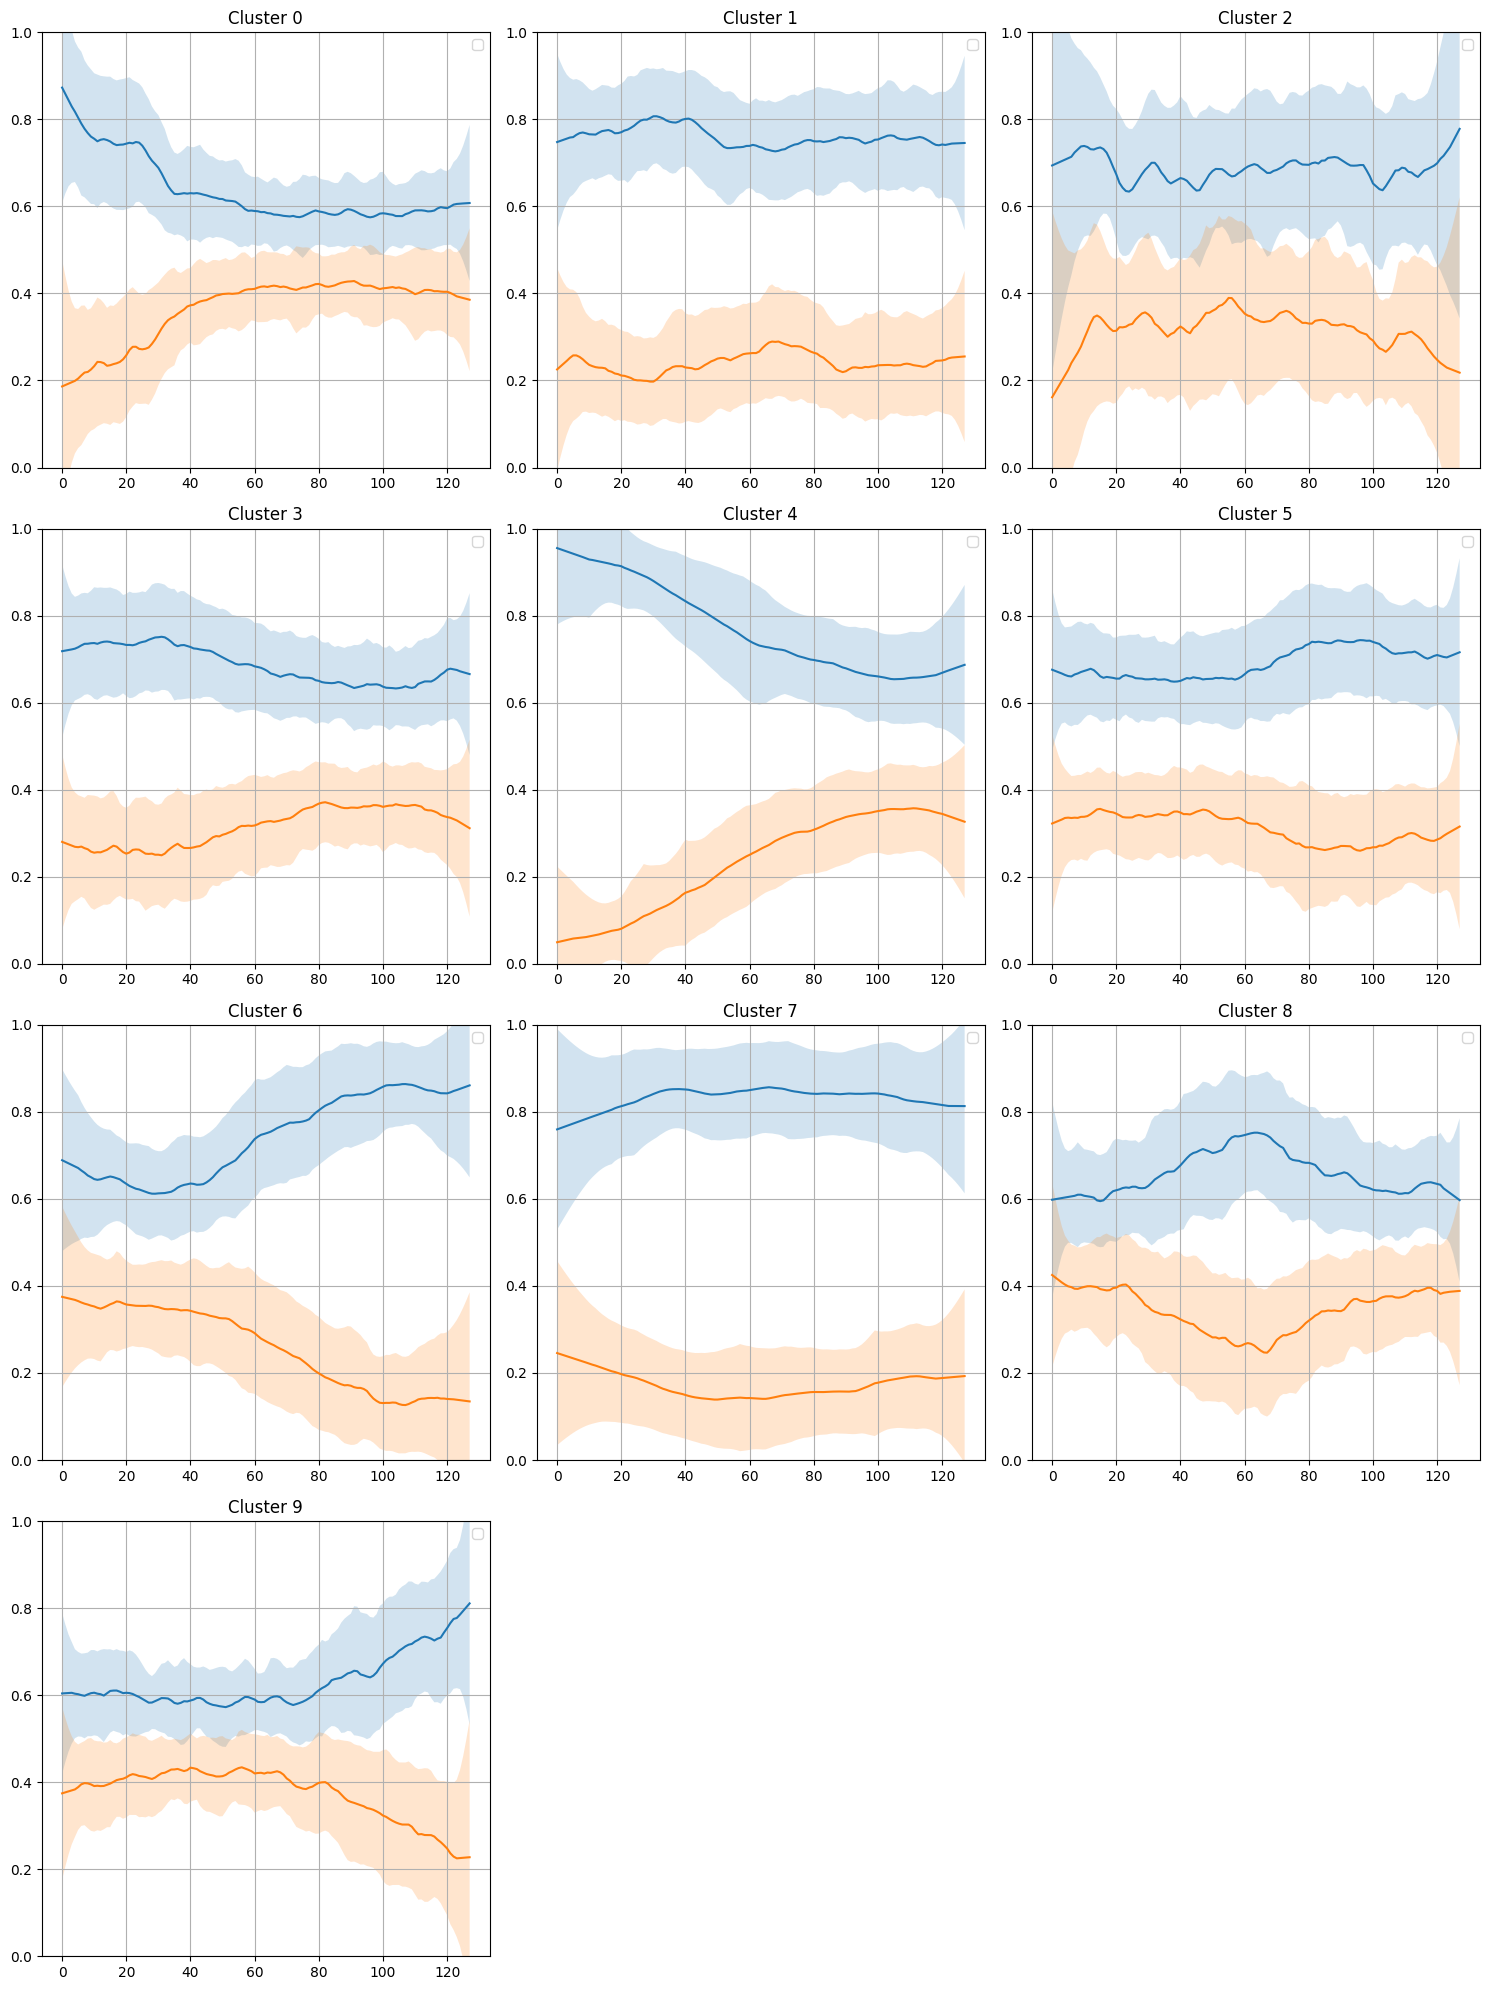

In [7]:
# Generar series temporales aleatorias
N  = 1000
indexes = np.arange(1, X_train.shape[0])
np.random.shuffle(indexes)

envolventes  = [extraer_envolventes(eliminar_pendiente(X_train[indexes[i]])) for i in range(N)]
series_temporales = np.abs(np.array(envolventes)[:N, 0] -  np.array(envolventes)[:N, 1])
series_temporales = np.array(envolventes)[:N, 0]
series_temporales = np.array(envolventes)[:N, :, :]


# Aplicar clustering con K-means y DTW
n_clusters = 10
labels, centroids, stds, kmeans = clusterizar_series_temporales(series_temporales, n_clusters, metric='dtw')
print("finalizado")
# Dibujar clusters
plot_clusters(series_temporales, labels, centroids, stds, n_clusters)

In [8]:
centroids[1].shape,series_temporales.shape

((2, 128), (1000, 2, 128))

In [9]:
def ajustar_pendiente_y_escalar(serie_temporal, pendiente_objetivo, tiempo=None):
    """
    Ajusta una serie temporal para que su pendiente de regresión sea la indicada,
    y escala los valores para que los máximos y mínimos coincidan con la serie original.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        pendiente_objetivo (float): Pendiente deseada para la línea de regresión.
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usará un índice lineal.

    Returns:
        numpy.ndarray: Serie temporal ajustada y escalada.
    """
    # Generar tiempo si no está dado
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Calcular la pendiente actual usando regresión lineal
    tiempo = tiempo.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(tiempo, serie_temporal)
    pendiente_actual = reg.coef_[0]
    
    # Calcular el ajuste necesario
    ajuste_pendiente = pendiente_objetivo #- pendiente_actual

    ajuste = ajuste_pendiente * tiempo.flatten()
    ajuste = ajuste - (ajuste.min() + (ajuste.max()-ajuste.min()) / 2) #- (serie_temporal.min() + (serie_temporal.max()-serie_temporal.min()) / 2)
    
    # Modificar la serie para lograr la pendiente deseada
    serie_ajustada = serie_temporal + ajuste
    
    # Escalar la serie ajustada para que sus máximos y mínimos coincidan con los originales
    #min_original, max_original = serie_temporal.min(), serie_temporal.max()
    #min_ajustada, max_ajustada = serie_ajustada.min(), serie_ajustada.max()
    
    # Escalamiento lineal
    serie_escalada = serie_ajustada
    #serie_escalada = ((serie_ajustada - min_ajustada) / (max_ajustada - min_ajustada)) * (max_original - min_original) + min_original
    
    return serie_escalada

def ajustar_a_envolventes_preservando_forma(señal_original, envolvente_superior, envolvente_inferior):
    """
    Ajusta una señal para que sus máximos y mínimos locales coincidan exactamente con las envolventes,
    preservando la forma original de la señal.

    Args:
        señal_original (numpy.ndarray): Señal original (1D).
        envolvente_superior (numpy.ndarray): Envolvente superior (1D).
        envolvente_inferior (numpy.ndarray): Envolvente inferior (1D).

    Returns:
        numpy.ndarray: Señal ajustada respetando las envolventes y preservando la forma.
    """
    # Verificar que las envolventes tengan el mismo tamaño que la señal original
    if len(señal_original) != len(envolvente_superior) or len(señal_original) != len(envolvente_inferior):
        raise ValueError("Las envolventes y la señal original deben tener el mismo tamaño.")

    step = 16
    señal_ajustada = np.copy(señal_original)
    for i in np.arange(0, señal_ajustada.shape[0], step): 
        _min, _max = señal_ajustada[i:i+step].min(), señal_ajustada[i:i+step].max()
        
        señal_ajustada[i:i+step] = (señal_ajustada[i:i+step] - _min) / (_max - _min)
    señal_ajustada_scaled = np.copy(señal_ajustada)

    _emin, _emax = envolvente_inferior.min(), envolvente_superior.max()

    factor = 1 / (_emax - _emin)
    envolvente_inferior = (envolvente_inferior - _emin) * factor
    
    envolvente_superior = (envolvente_superior - _emin) * factor

    indexes = np.where(señal_ajustada >= 0.5)
    señal_ajustada[indexes] = señal_ajustada[indexes] * envolvente_superior[indexes]

    indexes = np.where(señal_ajustada < 0.5)
    señal_ajustada[indexes] = 1 - ((1 - señal_ajustada[indexes]) * (1- envolvente_inferior[indexes]))

    
    señal_ajustada = (señal_ajustada / factor) + _emin
    
    return señal_ajustada, señal_ajustada_scaled



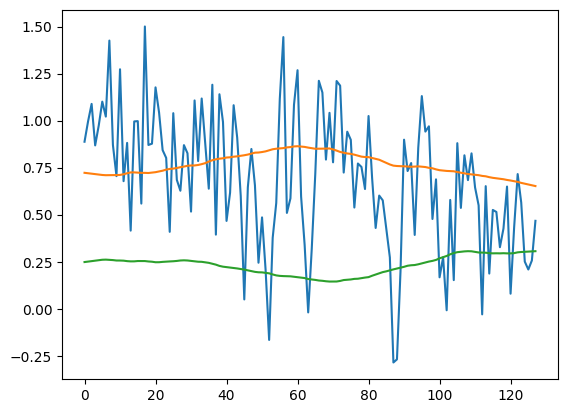

In [10]:
N = 100
time = np.linspace(0, 10, 128)
frec1 = np.random.uniform(0.1, 1, N) * np.pi
frec2 = np.random.uniform(0.1, 1, N) * np.pi
pend = np.random.uniform(-0.005, 0.005, N) 
noise = np.random.uniform(5, 10, N) 

def add_noise(x, snr):
    snr1 = 10 ** (snr / 10.0)
    xpower = np.mean(x ** 2, axis=0)
    npower = xpower / snr1

    center = np.random.normal(0, np.sqrt(npower))
    noise = np.random.normal(center, np.sqrt(npower), x.shape)
    noise_data = x + noise

    return noise_data

frencuencias = [np.random.uniform(0.1, 1, N) * np.pi for _ in range(20)]
X_sin = np.array([time] * N)

e = 1

for i in range(N):
    s = np.zeros((128,))
    for f in frencuencias:
        s += np.sin(X_sin[i] * 2 * f[i]) 
    s, _ = ajustar_a_envolventes_preservando_forma(s,  centroids[e][0], centroids[e][1])
    s = ajustar_pendiente_y_escalar(s, pend[i])
    s = add_noise(s, noise[i])
    X_sin[i] = s

i = 8
plt.plot(X_sin[i])
plt.plot(centroids[e][0])
plt.plot(centroids[e][1])

#plt.plot( ajustar_pendiente_y_escalar(centroids[e][0], pend[i]) )
#plt.plot( ajustar_pendiente_y_escalar(centroids[e][1], pend[i]) )


NameError: name 'noise_ratio' is not defined

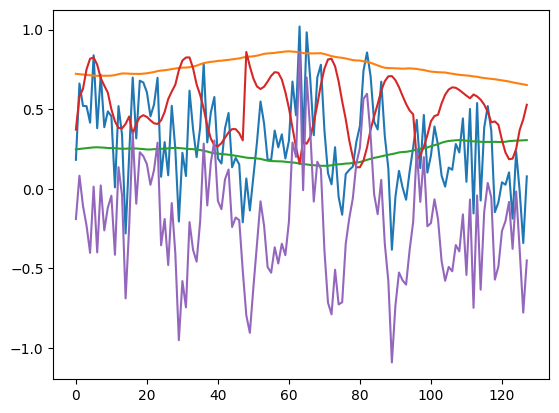

In [11]:
i = 2
s = np.zeros((128,))
frec1 = np.array(frencuencias)[:, i]
frec2 = [f * 2 * np.pi for f, _ in meta.extract_top_frequencies(X_sin[i], top_n=20)]
for f in frec2:
    s += np.sin(time * 2 * f) 

s, _ = ajustar_a_envolventes_preservando_forma(s,  centroids[e][0], centroids[e][1])
s = ajustar_pendiente_y_escalar(s, pend[i])


    
n = X_sin[i] - s
n = ajustar_pendiente_y_escalar(n, 0)
plt.plot(X_sin[i])
plt.plot(centroids[e][0])
plt.plot(centroids[e][1])
plt.plot(s)
plt.plot(n)
np.std(n), np.std(X_sin[i]), noise[i], noise_ratio(X_sin[i]), estimar_snr(X_sin[i])

In [12]:
frec1, frec2

(array([0.82140737, 1.48249218, 2.11202281, 0.4061461 , 2.15919347,
        0.48184741, 2.48800281, 0.8567779 , 1.51404192, 0.67593191,
        2.48068185, 0.73626112, 0.63716353, 2.52826891, 1.29369049,
        2.58155043, 2.02824655, 2.31961492, 1.08963102, 1.85758941]),
 [0.39269908169872414,
  0.2454369260617026,
  0.2945243112740431,
  0.09817477042468103,
  0.3436116964863836,
  0.04908738521234052,
  1.4726215563702154,
  2.5034566458293663,
  1.2762720155208536,
  2.84706834231575,
  2.7979809571034093,
  0.14726215563702155,
  0.4908738521234052,
  0.44178646691106466,
  1.9144080232812801,
  1.8653206380689396,
  1.6198837120072371,
  1.6689710972195777,
  3.043417883165112,
  2.2580197197676637])

In [19]:
from phm_framework.data import meta

frequences = np.array([[f for f, _ in meta.extract_top_frequencies(s, top_n=5)] for s in X_train])
frequences.mean(axis=0), frequences.std(axis=0)

(array([0.17149359, 0.17208894, 0.17052444, 0.16467548, 0.16041787]),
 array([0.10414501, 0.10436748, 0.10533035, 0.10585818, 0.10637994]))

In [13]:
chunks = 10

from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

dist = synthetic.generate_distributions(X_train, centroids, top_n=4)    

In [17]:
from phm_framework.data.synthetic import *

X = X_train
N = X_train.shape[0]
distributions = dist
Ns = np.array([d[-1]['N'] for d in dist])
Ns = np.array(np.round((Ns / np.sum(Ns)) * N), dtype=int) 

XX = np.zeros((N, X.shape[1]))
EE = np.zeros((N, 2, X.shape[1]))
i = 0
time = np.linspace(0, 10, X.shape[1])
for d, n in zip(distributions, Ns):
    for _ in range(n):
        frequencies = [np.random.normal(*f["frec_dist"]) for f in d]
        slope = np.random.normal(*d[-1]["slope_dist"])
        noise = np.random.normal(*d[-1]["noise_dist"])
        ienvelope = np.random.choice(np.arange(len(d[-1]["env_probs"])), p=d[-1]["env_probs"])
        eu, el = np.random.normal(centroids[ienvelope], stds[ienvelope]*0.5)
        EE[i, 0] =  eu
        EE[i, 1] =  el
        
        s = np.zeros((128,))
        for f in frequencies:
            s += np.sin(time * f) 
        
        s, _ = adjust_to_envelopes_preserving_shape(s,  eu, el)
        s = adjust_slope(s, slope)
        XX[i] = s
        
        i += 1


In [26]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

dist = synthetic.generate_synth_data(X_train)    

/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
